## 3. Evaluating our Boosting Model Signals

Evaluate the predictive performance of the cross-validation to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 252
idx = pd.IndexSlice

In [6]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']

In [7]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

#### Summary Metrics by Fold

Collect the summary metrics computed for each fold and hyperparameter combination:

In [8]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [9]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 0 to 4211
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          4212 non-null   int64  
 1   train_length       4212 non-null   int64  
 2   test_length        4212 non-null   int64  
 3   learning_rate      4212 non-null   float64
 4   num_leaves         4212 non-null   float64
 5   feature_fraction   4212 non-null   float64
 6   min_data_in_leaf   4212 non-null   float64
 7   daily_ic_mean      4212 non-null   float64
 8   daily_ic_mean_n    4212 non-null   float64
 9   daily_ic_median    4212 non-null   float64
 10  daily_ic_median_n  4212 non-null   float64
 11  boost_rounds       4212 non-null   int64  
 12  ic                 4212 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 460.7 KB


In [10]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          253           63             702
           1138          63             702
5          253           63             702
           1138          63             702
21         253           63             702
           1138          63             702
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [11]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [12]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [13]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [14]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086459 entries, 0 to 2122846
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              2086459 non-null  datetime64[ns]
 1   lookahead         2086459 non-null  int32         
 2   train_length      2086459 non-null  int32         
 3   test_length       2086459 non-null  int32         
 4   learning_rate     2086459 non-null  float64       
 5   num_leaves        2086459 non-null  int64         
 6   feature_fraction  2086459 non-null  float64       
 7   min_data_in_leaf  2086459 non-null  int64         
 8   boost_rounds      2086459 non-null  int32         
 9   ic                2086459 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2)
memory usage: 143.3 MB


In [15]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4211 entries, 0 to 4210
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4211 non-null   int64  
 1   train_length      4211 non-null   int64  
 2   test_length       4211 non-null   int64  
 3   learning_rate     4211 non-null   float64
 4   num_leaves        4211 non-null   int64  
 5   feature_fraction  4211 non-null   float64
 6   min_data_in_leaf  4211 non-null   int64  
 7   boost_rounds      4211 non-null   int64  
 8   ic                4211 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 296.2 KB


In [16]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

## HyperParameter Impact: Linear Regression

Run a linear regression using the various LightGBM hyperparameter settings as dummy variables and the daily validation IC as the outcome.


In [17]:
lin_reg = {}
for t in [1, 5, 21]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [18]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

IndexError: index 2 is out of bounds for axis 0 with size 2

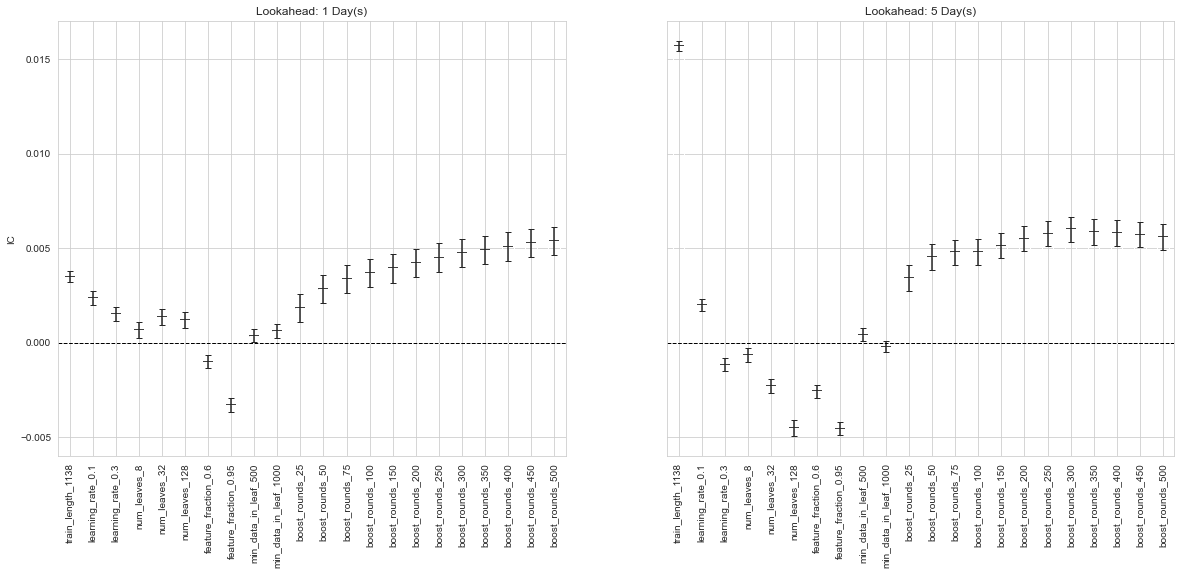

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 5, 21]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92);

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [ ]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
1129,1,1138,63,0.10,128,0.30,250,450,0.019295
1065,1,1138,63,0.10,32,0.30,1000,500,0.019098
1125,1,1138,63,0.10,128,0.30,250,250,0.018991
2439,5,1138,63,0.10,32,0.30,250,350,0.039301
2351,5,1138,63,0.10,8,0.30,250,500,0.039007
2441,5,1138,63,0.10,32,0.30,250,450,0.038886
3729,21,1138,63,0.01,128,0.95,500,500,0.102053
3728,21,1138,63,0.01,128,0.95,500,450,0.101508
3867,21,1138,63,0.10,32,0.60,1000,250,0.101255


In [ ]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [ ]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
304,1,1138,63,0.10,128.0,0.30,250.0,0.019295,450.0,0.021260,250.0,10,-0.014768
628,1,1138,63,0.10,128.0,0.30,250.0,0.019295,450.0,0.021260,250.0,25,-0.016416
952,1,1138,63,0.10,128.0,0.30,250.0,0.019295,450.0,0.021260,250.0,50,-0.018516
88,5,1138,63,0.10,32.0,0.30,250.0,0.039301,350.0,0.041697,350.0,10,-0.041366
412,5,1138,63,0.10,32.0,0.30,250.0,0.039301,350.0,0.041697,350.0,25,-0.047500
736,5,1138,63,0.10,32.0,0.30,250.0,0.039301,350.0,0.041697,350.0,50,-0.041180
210,21,1138,63,0.01,128.0,0.95,500.0,0.102053,500.0,0.102310,450.0,10,0.002313
534,21,1138,63,0.01,128.0,0.95,500.0,0.102053,500.0,0.102310,450.0,25,0.041455
858,21,1138,63,0.01,128.0,0.95,500.0,0.102053,500.0,0.102310,450.0,50,0.066539


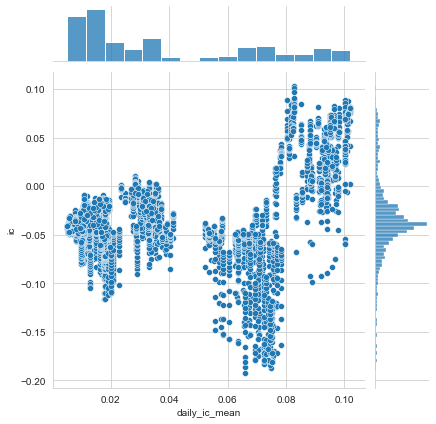

In [ ]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

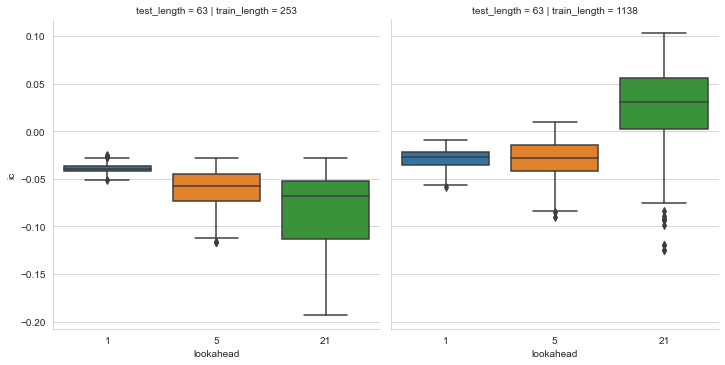

In [ ]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

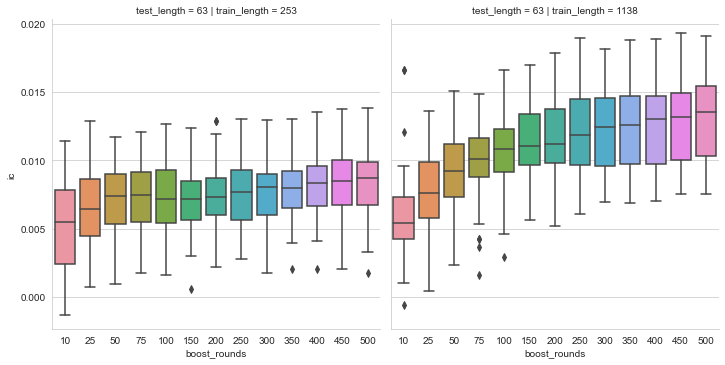

In [ ]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

## AlphaLens Analysis - Validation Performance

#### Select Parameters

In [ ]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4211 entries, 0 to 4210
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         4211 non-null   int64  
 1   train_length      4211 non-null   int64  
 2   test_length       4211 non-null   int64  
 3   learning_rate     4211 non-null   float64
 4   num_leaves        4211 non-null   int64  
 5   feature_fraction  4211 non-null   float64
 6   min_data_in_leaf  4211 non-null   int64  
 7   boost_rounds      4211 non-null   int64  
 8   ic                4211 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 329.0 KB


In [22]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [23]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [24]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        1138.0
test_length           63.0
learning_rate          0.1
num_leaves           128.0
feature_fraction       0.3
min_data_in_leaf     250.0
boost_rounds         450.0
Name: 1129, dtype: float64

In [25]:
best_params.to_hdf('data.h5', 'best_params')

#### Plot rolling IC

In [26]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

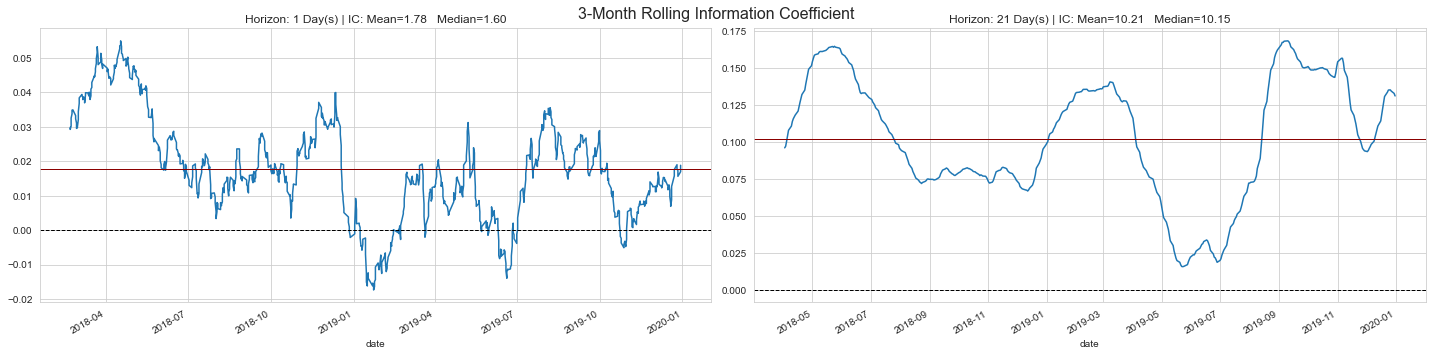

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [28]:
lookahead = 21
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [29]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}') # For later ingestion
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 478295 entries, ('AAON', Timestamp('2017-12-29 00:00:00')) to ('ZWS', Timestamp('2019-12-31 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       478295 non-null  float64
 1   1       478295 non-null  float64
 2   2       478295 non-null  float64
 3   3       478295 non-null  float64
 4   4       478295 non-null  float64
 5   5       478295 non-null  float64
 6   6       478295 non-null  float64
 7   7       478295 non-null  float64
 8   8       478295 non-null  float64
 9   9       478295 non-null  float64
dtypes: float64(10)
memory usage: 38.4+ MB


Using next available prices.

#### Get Trade Prices

In [36]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '/Users/Eric/Desktop/Model Creation/Gradient Boosters/data/prices' # h.5 file that was created in the end of 1_preparing_the_model_data
    prices = (pd.read_hdf(DATA_STORE, 'prices')).sort_index()
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2017': '2019'], 'open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [37]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [38]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 782 entries, 2017-01-02 00:00:00+00:00 to 2019-12-31 00:00:00+00:00
Columns: 949 entries, AAON to ZWS
dtypes: float64(949)
memory usage: 5.7 MB


In [39]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [40]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [41]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 4.0% entries from factor data: 4.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [42]:
# Code is taken from alphalens module, needed to rearrange because of multiindex
# issues with newer versions of pandas.

from pandas.tseries.offsets import CustomBusinessDay, Day, BusinessDay # need import to run infer_trading_calendar


def infer_trading_calendar(factor_idx, prices_idx):
    """
    Infer the trading calendar from factor and price information.

    Parameters
    ----------
    factor_idx : pd.DatetimeIndex
        The factor datetimes for which we are computing the forward returns
    prices_idx : pd.DatetimeIndex
        The prices datetimes associated withthe factor data

    Returns
    -------
    calendar : pd.DateOffset
    """
    full_idx = factor_idx.union(prices_idx)

    traded_weekdays = []
    holidays = []

    days_of_the_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for day, day_str in enumerate(days_of_the_week):

        weekday_mask = (full_idx.dayofweek == day)

        # drop days of the week that are not traded at all
        if not weekday_mask.any():
            continue
        traded_weekdays.append(day_str)

        # look for holidays
        used_weekdays = full_idx[weekday_mask].normalize()
        all_weekdays = pd.date_range(full_idx.min(), full_idx.max(),
                                     freq=CustomBusinessDay(weekmask=day_str)
                                     ).normalize()
        _holidays = all_weekdays.difference(used_weekdays)
        _holidays = [timestamp.date() for timestamp in _holidays]
        holidays.extend(_holidays)

    traded_weekdays = ' '.join(traded_weekdays)
    return CustomBusinessDay(weekmask=traded_weekdays, holidays=holidays)


In [43]:
# Needed to set the freq. of the datetime index, and match formatting for Alphalens.
# Workaround for the multiindex. 

factor_dateindex = factor.index.levels[0]
freq = infer_trading_calendar(factor_dateindex, trade_prices.index)
factor_data = factor_data.unstack().asfreq(freq).stack()
factor_data.index.names = ['date', 'asset']
factor_data

1D        5D       10D       21D  \
date                      asset                                           
2017-12-29 00:00:00+00:00 AAON   0.001355  0.028455 -0.013550 -0.024390   
                          AAT   -0.005969 -0.036854 -0.056839 -0.094212   
                          AAWW  -0.014298 -0.049622  0.035324 -0.019344   
                          ABCB  -0.006148  0.031762  0.079918  0.121926   
                          ABG   -0.018321  0.022137  0.140458  0.145802   
...                                   ...       ...       ...       ...   
2019-12-02 00:00:00+00:00 YELP   0.030615 -0.000909  0.022734  0.041225   
                          YORW  -0.002044  0.013854  0.032478  0.053600   
                          ZD     0.012172  0.008574  0.015982 -0.006880   
                          ZUMZ   0.008964  0.148074  0.045153  0.126494   
                          ZWS    0.000327  0.024636  0.059972  0.059318   

                                   factor  factor_quantile  
date                      asset                             
2017-12-29 00:00:00+00:00 AAON   0.014118              2.0  
                          AAT    0.035909              5.0  
                          AAWW   0.024416              4.0  
                          ABCB   0.010976              2.0  
                          ABG    0.024303              4.0  
...                                   ...              ...  
2019-12-02 00:00:00+00:00 YELP   0.000374              4.0  
                          YORW   0.000341              4.0  
                          ZD    -0.003356              3.0  
                          ZUMZ  -0.000948              3.0  
                          ZWS   -0.005916              2.0  

[459314 rows x 6 columns]

In [44]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [45]:
factor_returns = perf.factor_returns(factor_data)

In [46]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [47]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [48]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

,1D,5D,10D,21D
Mean Period Wise Spread (bps),15.720335,17.014730,16.929134,16.470882
Ann. alpha,0.252123,0.276402,0.268262,0.252860
beta,0.094519,0.163751,0.215069,0.178719


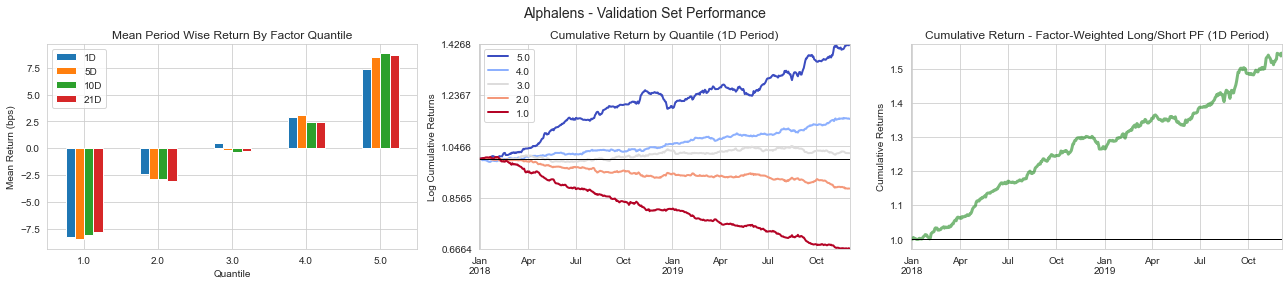

In [49]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.180808,0.073496,-0.017615,0.025855,91960,20.021162
2.0,-0.054067,0.087207,-0.001351,0.023864,91958,20.020727
3.0,-0.046125,0.098074,0.006492,0.024779,91478,19.916223
4.0,-0.039809,0.112565,0.014558,0.025813,91958,20.020727
5.0,-0.031554,0.394097,0.038004,0.038904,91960,20.021162


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.252,0.276,0.268,0.253
beta,0.095,0.164,0.215,0.179
Mean Period Wise Return Top Quantile (bps),7.402,8.537,8.865,8.670
Mean Period Wise Return Bottom Quantile (bps),-8.319,-8.525,-8.124,-7.851
Mean Period Wise Spread (bps),15.720,17.015,16.929,16.471


Information Analysis


,1D,5D,10D,21D
IC Mean,0.015,0.048,0.069,0.103
IC Std.,0.086,0.092,0.099,0.089
Risk-Adjusted IC,0.177,0.521,0.697,1.157
t-stat(IC),NaN,11.469,15.344,25.462
p-value(IC),NaN,0.000,0.000,0.000
IC Skew,NaN,-0.021,0.312,0.294
IC Kurtosis,NaN,0.440,1.440,1.549


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.499,0.216,0.609,0.391
Quantile 2 Mean Turnover,0.696,0.453,0.740,0.632
Quantile 3 Mean Turnover,0.725,0.508,0.757,0.671
Quantile 4 Mean Turnover,0.686,0.446,0.737,0.620
Quantile 5 Mean Turnover,0.440,0.207,0.530,0.352


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.897,0.718,0.578,0.408


<Figure size 432x288 with 0 Axes>

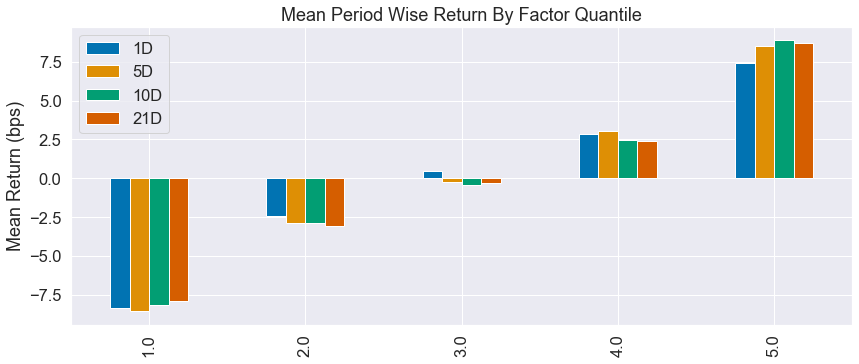

In [50]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.180808,0.073496,-0.017615,0.025855,91960,20.021162
2.0,-0.054067,0.087207,-0.001351,0.023864,91958,20.020727
3.0,-0.046125,0.098074,0.006492,0.024779,91478,19.916223
4.0,-0.039809,0.112565,0.014558,0.025813,91958,20.020727
5.0,-0.031554,0.394097,0.038004,0.038904,91960,20.021162


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.252,0.276,0.268,0.253
beta,0.095,0.164,0.215,0.179
Mean Period Wise Return Top Quantile (bps),7.402,8.537,8.865,8.670
Mean Period Wise Return Bottom Quantile (bps),-8.319,-8.525,-8.124,-7.851
Mean Period Wise Spread (bps),15.720,17.015,16.929,16.471


<Figure size 432x288 with 0 Axes>

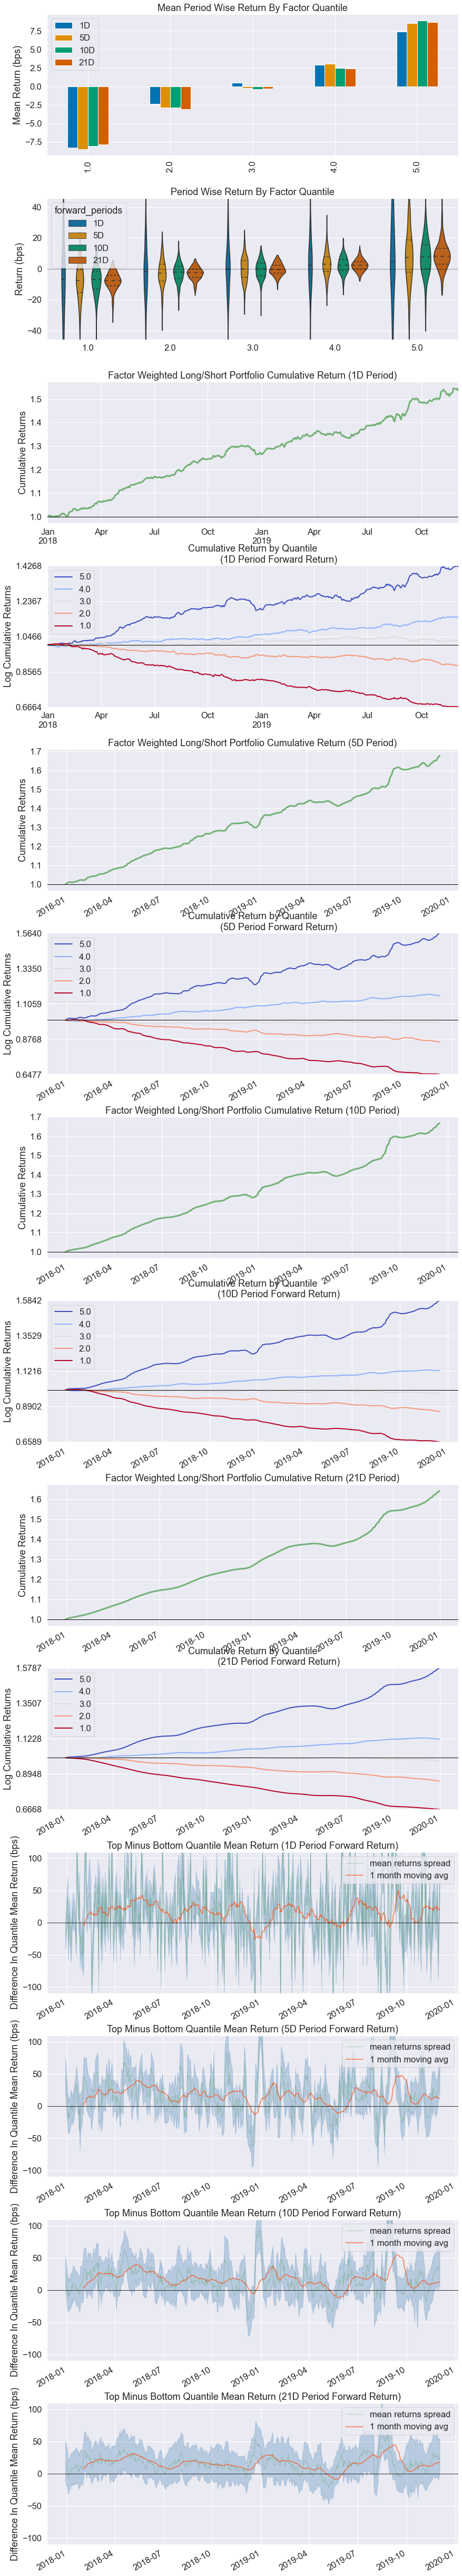

Information Analysis


,1D,5D,10D,21D
IC Mean,0.015,0.048,0.069,0.103
IC Std.,0.086,0.092,0.099,0.089
Risk-Adjusted IC,0.177,0.521,0.697,1.157
t-stat(IC),NaN,11.469,15.344,25.462
p-value(IC),NaN,0.000,0.000,0.000
IC Skew,NaN,-0.021,0.312,0.294
IC Kurtosis,NaN,0.440,1.440,1.549


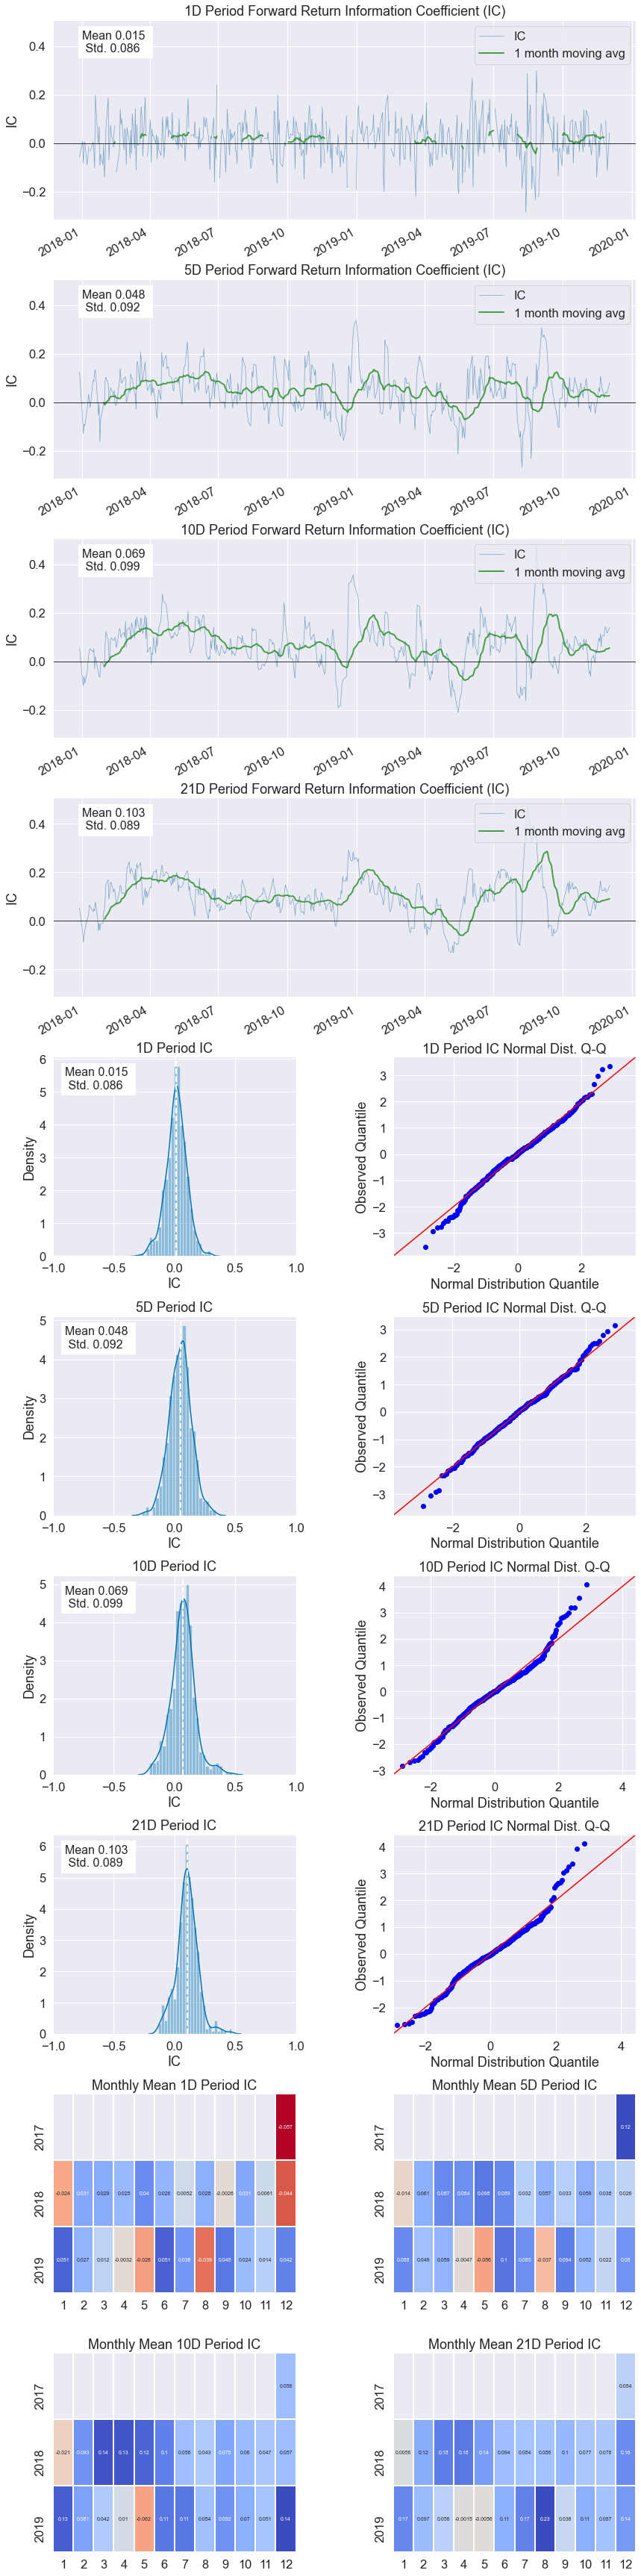

Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.499,0.216,0.609,0.391
Quantile 2 Mean Turnover,0.696,0.453,0.740,0.632
Quantile 3 Mean Turnover,0.725,0.508,0.757,0.671
Quantile 4 Mean Turnover,0.686,0.446,0.737,0.620
Quantile 5 Mean Turnover,0.440,0.207,0.530,0.352


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.897,0.718,0.578,0.408


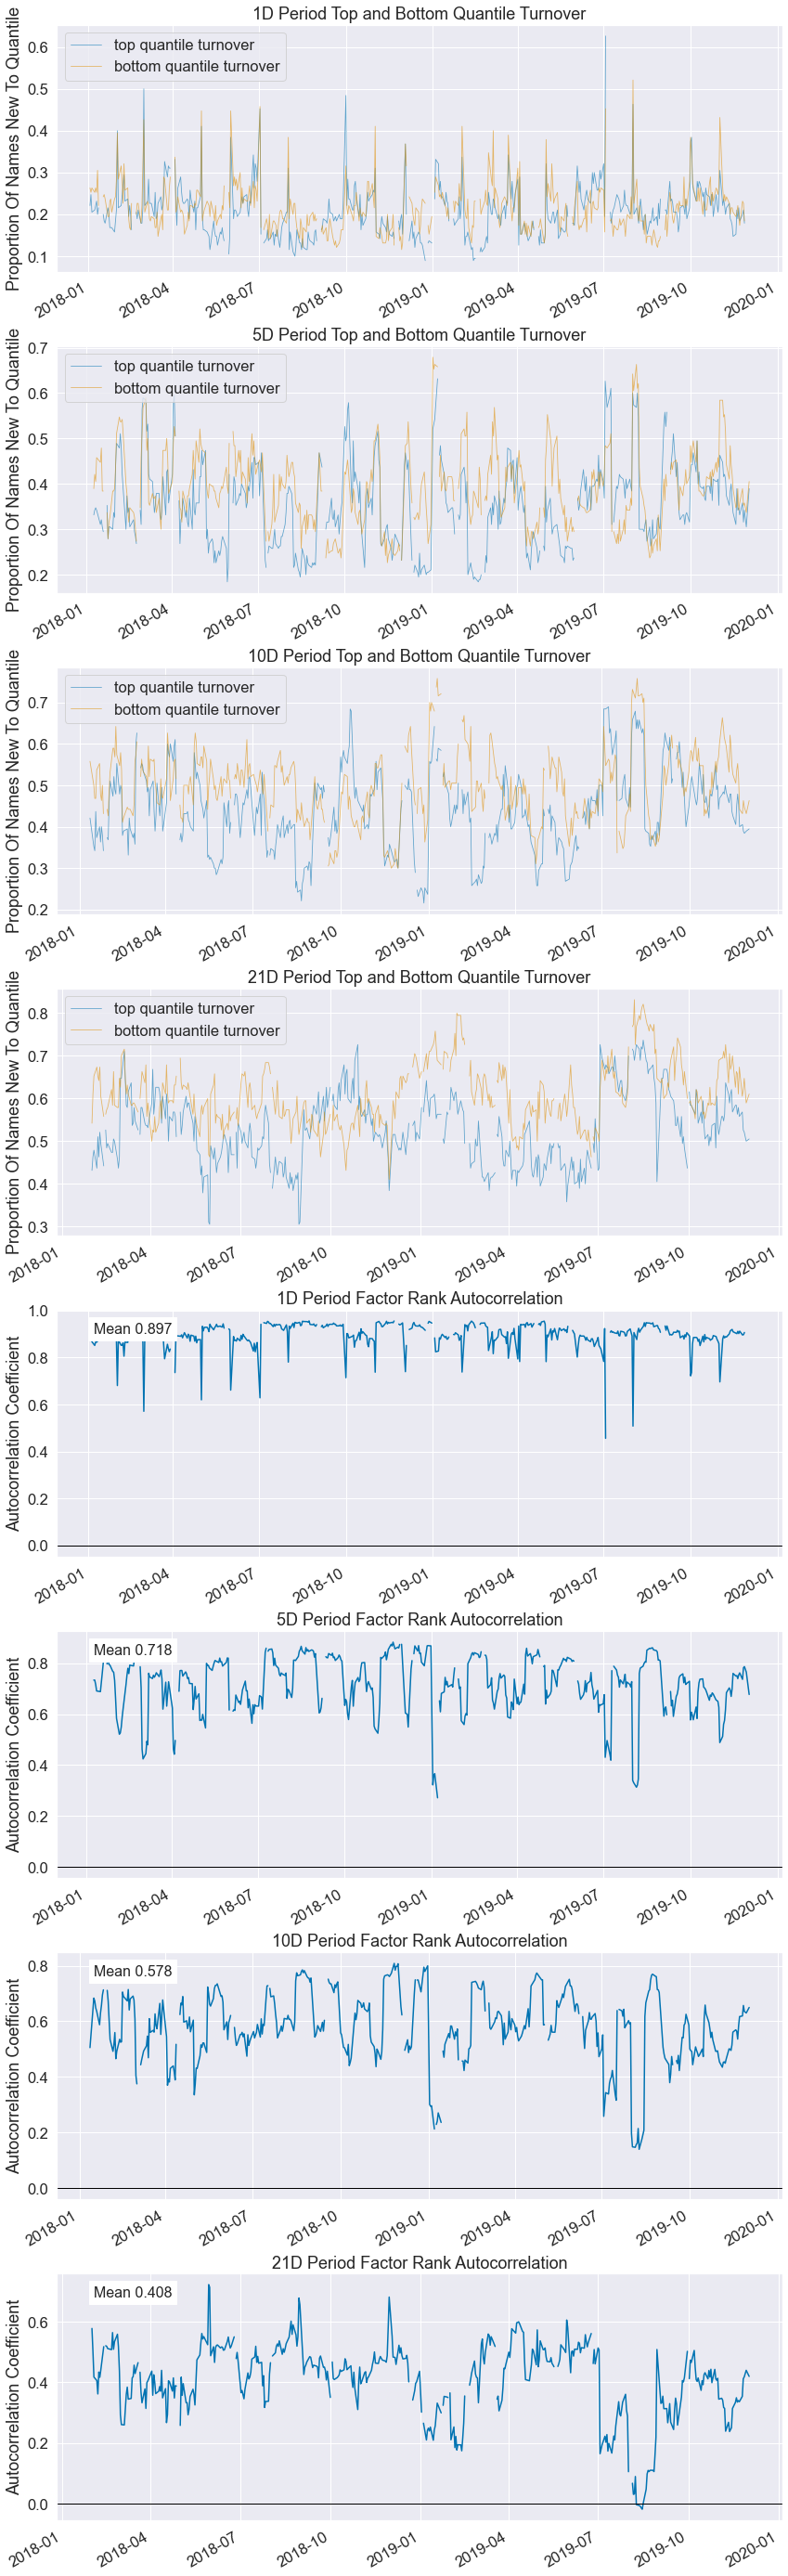

In [51]:
create_full_tear_sheet(factor_data)